# Second Approch

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from sympy import Symbol
import copy as cp
import seaborn as sns
from scipy.linalg import cholesky
from math import sqrt
from numpy import shape

In this approch, the objectif is to use the modeling equation (1) of $H$, the water level of the watercourse, in order to minimize the overflow height, $S$, that is related to the physical variables and the height of the dike by the equation (2).

$H = {\left(\frac{Q}{K_s \sqrt(\frac{Z_m - Z_v}{L}) B}\right)}^{\frac{3}{5}} \ (1)$

$S = Z_c - Z_d = Zv + H - \mathcal{H}_d - Z_b \ (2) $

By the formulation of the problem, the major sources of uncertainty are considered to be the variables $Q$, $Z_m$, $Z_v$ and $K_s$. In this sense these variables are considered to be random variables with the following distributions :

$Q \sim Gumbel(1013, 558)$

$Z_m \sim Triangular(55, halfrange = 1)$

$Z_v \sim Triangular(50, halfrange = 1)$

$K_s \sim \mathcal{N}(30, 7.5)$

The other variables, $B$, $L$ and $Z_b$, are considered to be deterministics with values 300, 5000 and 55,5 respectively.

For the development that follows, it will be considered the 3 different scenarios:

1) Random variables without correlation

2) Correlation $K_s$-$Z_v$ of -0.6 and $Z_v$-$Z_m$ of 0.6

3) Correlation $K_s$-$Z_v$ of -0.3, $Z_v$-$Z_m$ of 0.66 and $K_s$-$Z_m$ of -0.5

-----

1) Generating realisations of the random variables and defining constants for the 3 scenarios

In [64]:
N = 1000000

#first scenario
q_realisations = np.random.gumbel(1031,558,N)
zm_realisations = np.random.triangular(54,55,56,N)
zv_realisations = np.random.triangular(49,50,51,N)
ks_realisations = np.random.normal(30,7.5,N)

i=0
while i < q_realisations.shape[0]:
    if ks_realisations[i] < 0 or q_realisations[i]<0:
        q_realisations = np.delete(q_realisations,i)
        zm_realisations = np.delete(zm_realisations,i)
        zv_realisations = np.delete(zv_realisations,i)
        ks_realisations = np.delete(ks_realisations,i)
    else:
        i+=1    

#second scenario
cov_matrix2 = np.array([
        [  1, -0.6, 0],
        [ -0.6,  1,  0.6],
        [ 0,  0.6,  1]
    ])

c2 = cholesky(cov_matrix2, lower=True)

realisations_2 =np.zeros([q_realisations.shape[0],4])
for i in range(q_realisations.shape[0]):
    uncorrelated_var_i = [ks_realisations[i],zv_realisations[i],zm_realisations[i]]
    correlated_var_i = np.dot(c2,uncorrelated_var_i)
    realisations_2[i][:]=[q_realisations[i],correlated_var_i[0],correlated_var_i[1],correlated_var_i[2]]

#third scenario
cov_matrix3 = np.array([
        [  1, -0.3, -0.5],
        [ -0.3,  1,  0.66],
        [ -0.5,  0.66,  1]
    ])

c3 = cholesky(cov_matrix3, lower=True)


realisations_3 = np.zeros([q_realisations.shape[0],4])
for i in range(q_realisations.shape[0]):
    uncorrelated_var_i = [ks_realisations[i],zv_realisations[i],zm_realisations[i]]
    correlated_var_i = np.dot(c3,uncorrelated_var_i)
    realisations_3[i][:]=[q_realisations[i],correlated_var_i[0],correlated_var_i[1],correlated_var_i[2]]



B=300
L=5000
Zb=55.5

2) Generating H in the diferent scenarios

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

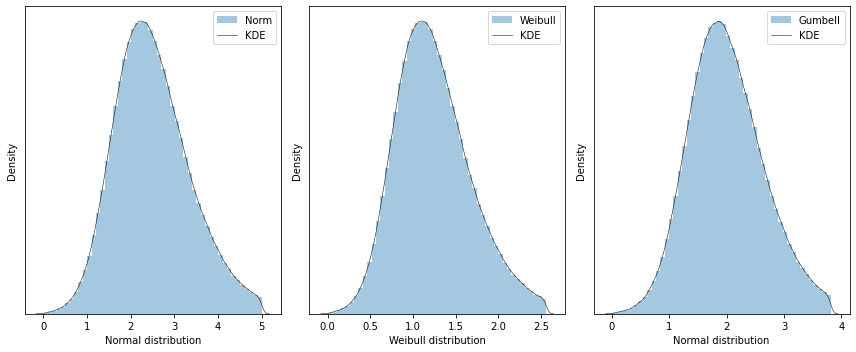

In [84]:
#first scenario

H_1 = np.zeros(q_realisations.shape[0])
for i in range(q_realisations.shape[0]):
    Q_1 = np.power(q_realisations[i],3/5)
    Div_1 = np.power(1/(ks_realisations[i]*sqrt((zm_realisations[i]-zv_realisations[i])/L)*B),3/5)
    H_1[i]=(Q_1*Div_1)

        

#second scenario

H_2 = np.zeros(len(realisations_2))
for i in range(len(realisations_2)):
    Q_2 = np.power(realisations_2[i][0],3/5)
    Div_2 = np.power(1/(realisations_2[i][1]*sqrt((realisations_2[i][3]-realisations_2[i][2])/L)*B),3/5)
    H_2[i]=(Q_2*Div_2)


#third scenario

H_3 = np.zeros(len(realisations_3))
for i in range(len(realisations_3)):
    Q_3 = np.power(realisations_3[i][0],3/5)
    Div_3 = np.power(1/(realisations_3[i][1]*sqrt((realisations_3[i][3]-realisations_3[i][2])/L)*B),3/5)
    H_3[i]=(Q_3*Div_3)

H_1 = np.sort(H_1)
H_2 = np.sort(H_2)
H_3 = np.sort(H_3)

fig, ax = plt.subplots(1,3,figsize=(12,5))

sns.distplot(H_1[1:980000],ax=ax[0],label='Norm',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[0].set_yticks([])
ax[0].set_xlabel('Normal distribution')
ax[0].legend()
sns.distplot(H_2[1:980000],ax=ax[1],label='Weibull',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[1].set_yticks([])
ax[1].set_xlabel('Weibull distribution')
ax[1].legend()
sns.distplot(H_3[1:980000],ax=ax[2],label='Gumbell',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[2].set_yticks([])
ax[2].set_xlabel('Normal distribution')
ax[2].legend()
plt.tight_layout()
# plt.savefig('Fig4.eps',format = 'eps')
plt.show()

3) Computing the realisations of S with $\mathcal{H}_d = 0$

C:\Users\analu\AppData\Local\Temp\ipykernel_29168\4244279740.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  VaR1=np.quantile(S_1,0.95,interpolation= 'higher')
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


9.89593953060276


c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


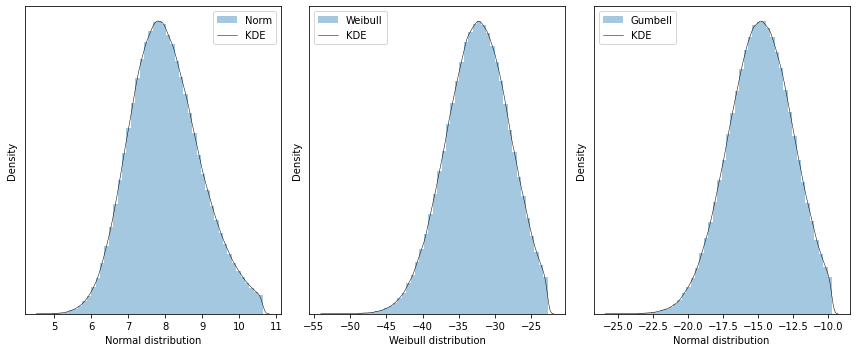

In [87]:
#first scenario

S_1 = np.sort(-zv_realisations + H_1 + Zb*np.ones(zv_realisations.shape[0]))
S_2 = np.sort(realisations_2[:,2] + H_2 - Zb*np.ones(zv_realisations.shape[0]))
S_3 = np.sort(realisations_3[:,2] + H_3 - Zb*np.ones(zv_realisations.shape[0]))
VaR1=np.quantile(S_1,0.95,interpolation= 'higher')
print(VaR1)

fig, ax = plt.subplots(1,3,figsize=(12,5))

sns.distplot(S_1[1:980000],ax=ax[0],label='Norm',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[0].set_yticks([])
ax[0].set_xlabel('Normal distribution')
ax[0].legend()
sns.distplot(S_2[1:980000],ax=ax[1],label='Weibull',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[1].set_yticks([])
ax[1].set_xlabel('Weibull distribution')
ax[1].legend()
sns.distplot(S_3[1:980000],ax=ax[2],label='Gumbell',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[2].set_yticks([])
ax[2].set_xlabel('Normal distribution')
ax[2].legend()
plt.tight_layout()
# plt.savefig('Fig4.eps',format = 'eps')
plt.show()